# FOOD DEMAND FORECASTING - Project Report and Code

# Libraries

In [5]:
# Data Analysis and Wrangling
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


## Acquire Data

The Python Pandas packages helps us work with our datasets. We start by acquiring the dataset into Pandas DataFrames.

In [6]:
# Load the Excel file into a DataFrame
df = pd.read_csv("food.csv")

# DATA EXPLORATION

In [7]:
# Display columns and the first few rows of the DataFrame
print(df.columns.values)
print(df.head())

['id' 'week' 'center_id' 'meal_id' 'checkout_price' 'base_price'
 'emailer_for_promotion' 'homepage_featured' 'num_orders']
        id  week  center_id  meal_id  checkout_price  base_price  \
0  1379560     1         55     1885          136.83      152.29   
1  1466964     1         55     1993          136.83      135.83   
2  1346989     1         55     2539          134.86      135.86   
3  1338232     1         55     2139          339.50      437.53   
4  1448490     1         55     2631          243.50      242.50   

   emailer_for_promotion  homepage_featured  num_orders  
0                      0                  0         177  
1                      0                  0         270  
2                      0                  0         189  
3                      0                  0          54  
4                      0                  0          40  


In [8]:
# Check for missing values in each column of the 'df' DataFrame
missing_values = df.isnull().sum()
print(missing_values)

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64


In [9]:
# Check for duplicates
duplicates = df.duplicated()

# Count the total number of duplicate rows
total_duplicates = duplicates.sum()
print("Total duplicates:", total_duplicates)

# Display the duplicate rows themselves
duplicate_rows = df[duplicates]
print("Duplicate rows:\n", duplicate_rows)

Total duplicates: 0
Duplicate rows:
 Empty DataFrame
Columns: [id, week, center_id, meal_id, checkout_price, base_price, emailer_for_promotion, homepage_featured, num_orders]
Index: []


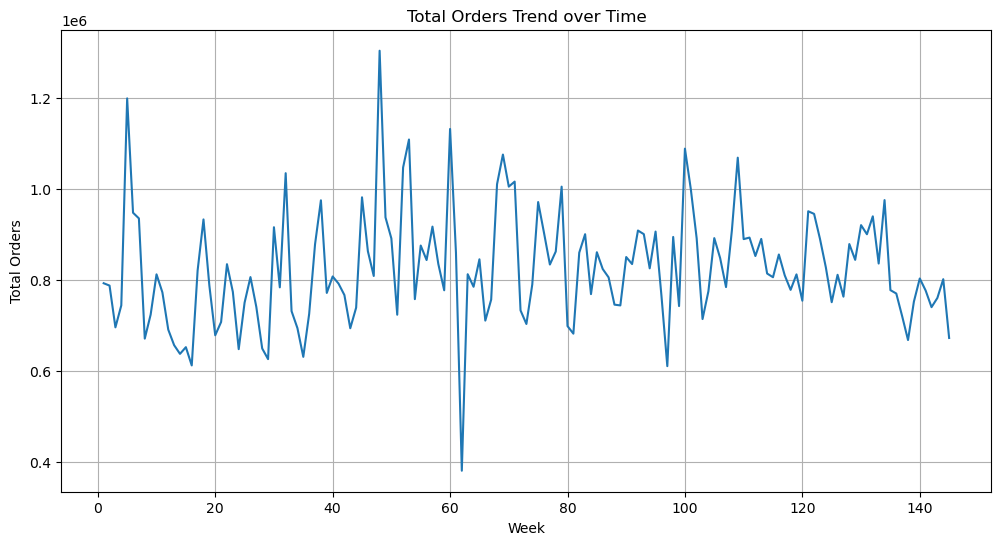

In [10]:
# Line Plot: Trend of Total Orders over Time
order_trend = df.groupby('week')['num_orders'].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(order_trend['week'], order_trend['num_orders'])
plt.xlabel('Week')
plt.ylabel('Total Orders')
plt.title('Total Orders Trend over Time')
plt.grid(True)  # Add grid lines for better readability
plt.show()

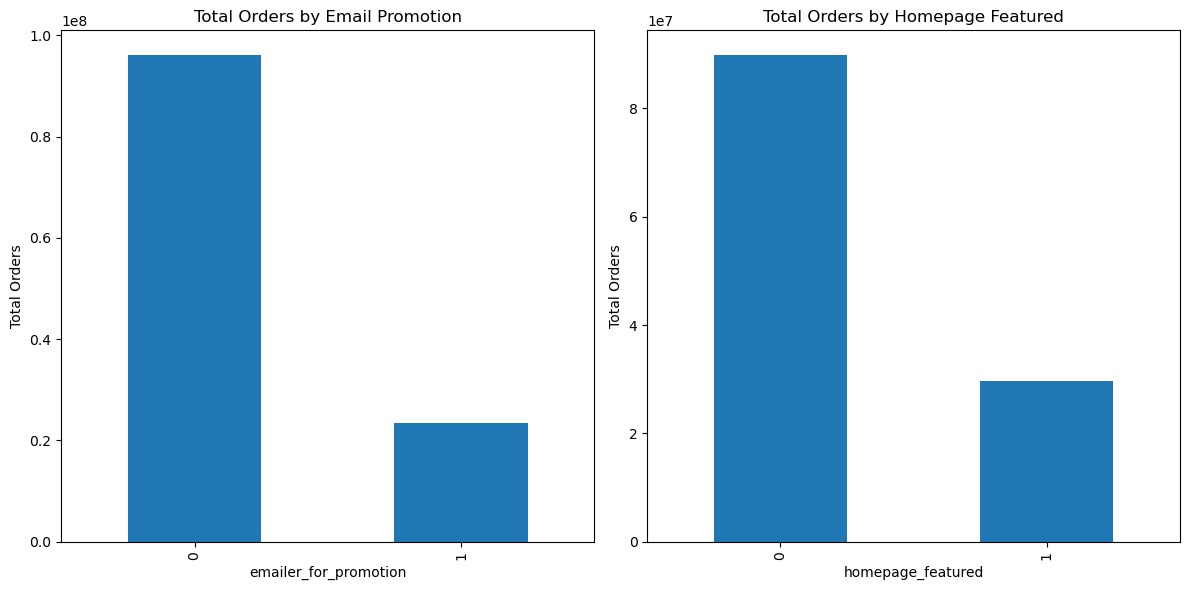

In [11]:
# Bar Plot: Breakdown of Total Orders by 'emailer_for_promotion' and 'homepage_featured'
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

df.groupby('emailer_for_promotion')['num_orders'].sum().plot(kind='bar', ax=axs[0])
axs[0].set_title('Total Orders by Email Promotion')
axs[0].set_ylabel('Total Orders')

df.groupby('homepage_featured')['num_orders'].sum().plot(kind='bar', ax=axs[1])
axs[1].set_title('Total Orders by Homepage Featured')
axs[1].set_ylabel('Total Orders')

plt.tight_layout()
plt.show()

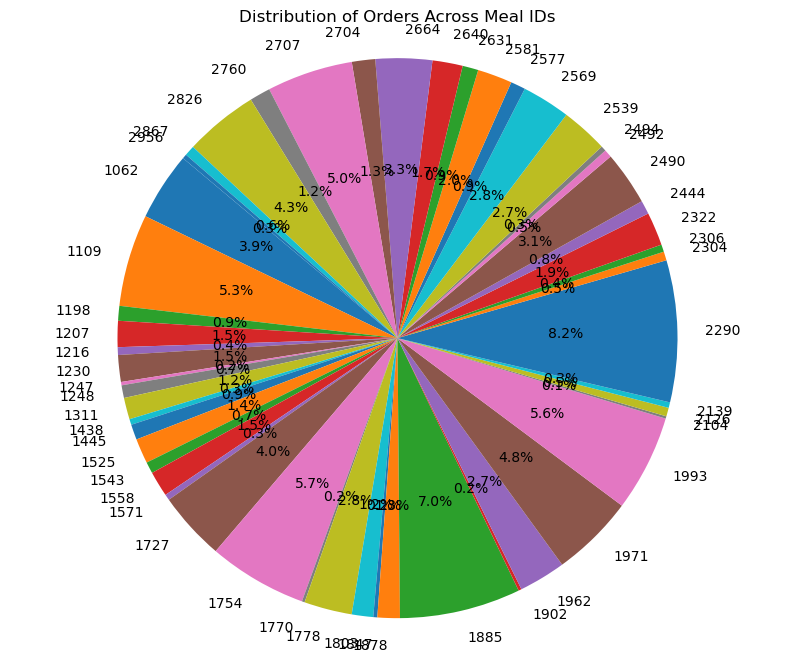

In [12]:
# Grouping the data by 'meal_id' and calculating the total orders for each meal
orders_by_meal = df.groupby('meal_id')['num_orders'].sum()

# Creating the pie chart
plt.figure(figsize=(10, 8))
plt.pie(orders_by_meal, labels=orders_by_meal.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribution of Orders Across Meal IDs')
plt.show()

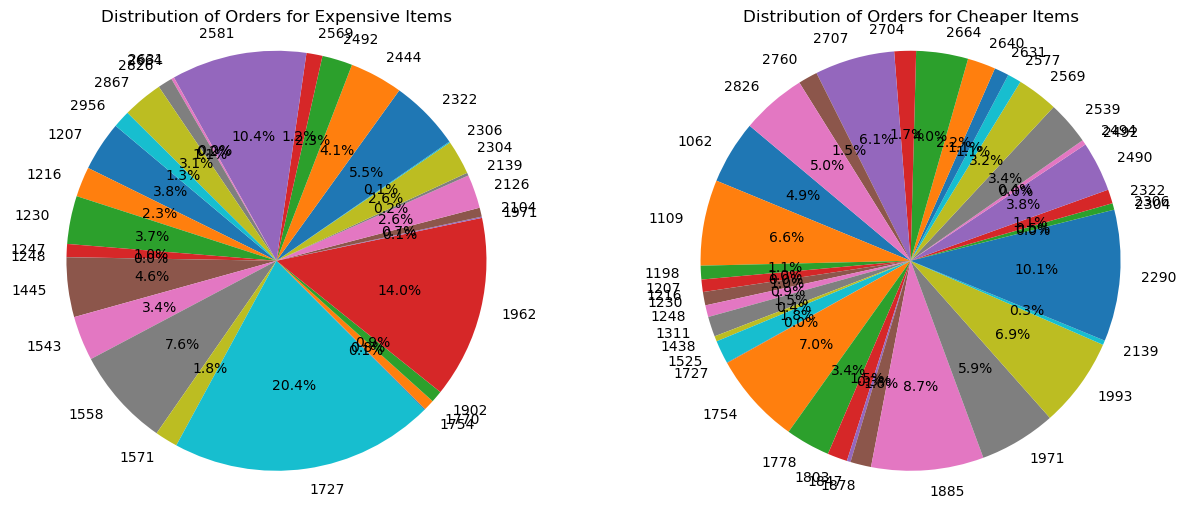

In [13]:
# Define the threshold price to separate expensive and cheaper items
price_threshold = df['base_price'].mean()  

# Create two DataFrames for expensive and cheaper items based on the defined threshold
expensive_items = df[df['base_price'] > price_threshold]
cheaper_items = df[df['base_price'] <= price_threshold]

# Grouping the data by 'meal_id' for expensive and cheaper items
orders_expensive = expensive_items.groupby('meal_id')['num_orders'].sum()
orders_cheaper = cheaper_items.groupby('meal_id')['num_orders'].sum()

# Creating two pie charts for expensive and cheaper items
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart for expensive items
axs[0].pie(orders_expensive, labels=orders_expensive.index, autopct='%1.1f%%', startangle=140)
axs[0].axis('equal')
axs[0].set_title('Distribution of Orders for Expensive Items')

# Pie chart for cheaper items
axs[1].pie(orders_cheaper, labels=orders_cheaper.index, autopct='%1.1f%%', startangle=140)
axs[1].axis('equal')
axs[1].set_title('Distribution of Orders for Cheaper Items')

plt.show()

# DATA TRANSFORMATION

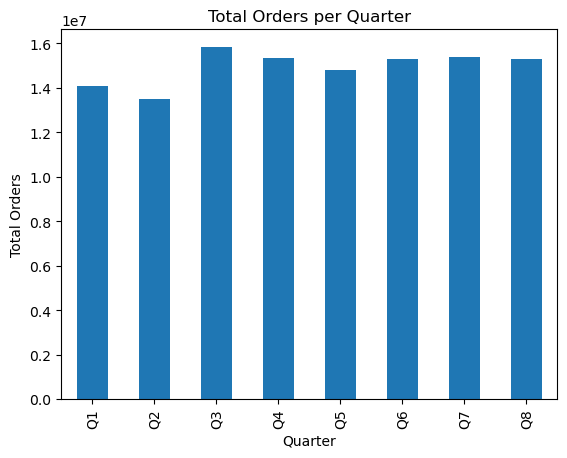

In [14]:
# Define the 8 quarters based on weeks (145 weeks division)
quarters = pd.cut(df['week'], bins=[0, 18, 36, 54, 72, 90, 108, 126, 145], labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8'])

# Add the 'quarter' column to the DataFrame
df['quarter'] = quarters

# Group the data by quarter and perform aggregations
quarterly_data = df.groupby('quarter').agg({
    'num_orders': 'sum',
    'checkout_price': 'mean',
})

# Visualize the total orders per quarter
quarterly_data['num_orders'].plot(kind='bar', xlabel='Quarter', ylabel='Total Orders', title='Total Orders per Quarter')
plt.show()

In [15]:
# Ouliers detection
# Selecting numerical columns for outlier detection
numerical_cols = ['checkout_price', 'base_price', 'num_orders']

# Calculate z-scores for the selected numerical columns
z_scores = np.abs((df[numerical_cols] - df[numerical_cols].mean()) / df[numerical_cols].std())

# Define a threshold for outlier detection (e.g., z-score > 3)
outlier_threshold = 3

# Identifying rows with outliers in any of the numerical columns
outlier_rows = df[(z_scores > outlier_threshold).any(axis=1)]

# Display the rows containing outliers
print("Rows with outliers:")
print(outlier_rows)

Rows with outliers:
             id  week  center_id  meal_id  checkout_price  base_price  \
33      1040403     1         24     1885          136.83      136.83   
85      1309667     1         11     2707          190.12      192.12   
91      1426280     1         11     1109          237.68      262.90   
194     1171094     1         13     1885          135.86      122.28   
195     1068455     1         13     1993          134.86      122.28   
...         ...   ...        ...      ...             ...         ...   
456074  1182382   145         43     1885          158.14      157.14   
456082  1477003   145         43     2707          235.77      235.77   
456086  1270005   145         43     2290          298.82      298.82   
456088  1330371   145         43     1109          283.30      283.30   
456281  1038629   145        132     1885          160.11      148.41   

        emailer_for_promotion  homepage_featured  num_orders quarter  
33                          0   

Text(0.5, 1.0, 'Boxplot of Numerical Columns before Outlier Amputation')

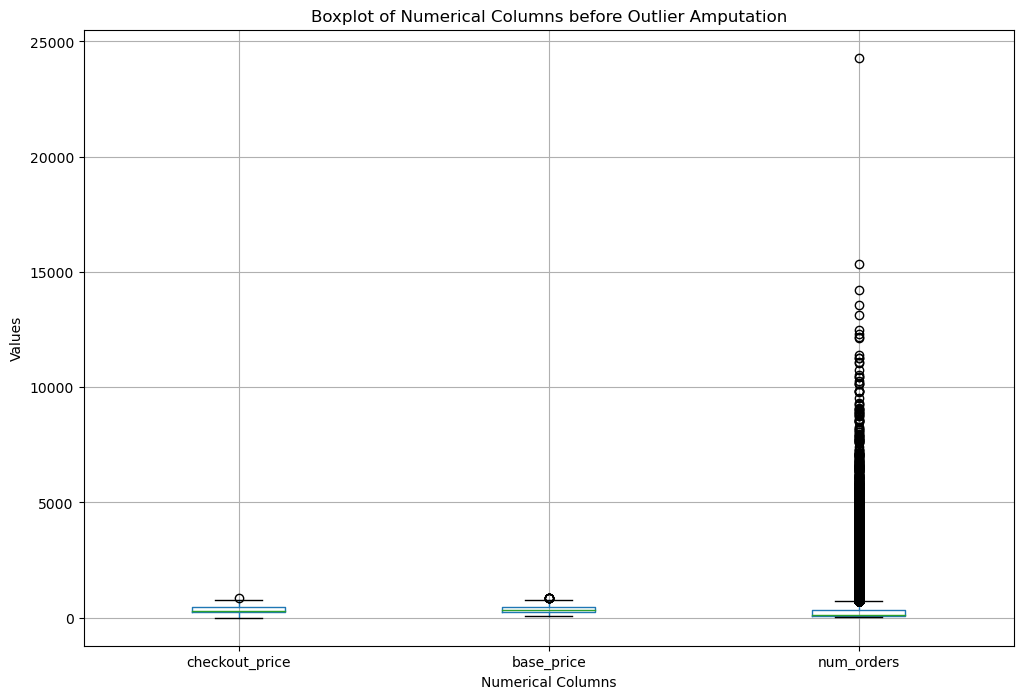

In [16]:
# Boxplots to visualize the distribution of numerical variables
plt.figure(figsize=(12, 8))
numerical_cols = ['checkout_price', 'base_price', 'num_orders']
df[numerical_cols].boxplot()

plt.xlabel('Numerical Columns')
plt.ylabel('Values')
plt.title('Boxplot of Numerical Columns before Outlier Amputation')

In [17]:
# Define the percentage to trim from each end
trim_percentage = 0.05

# Calculate the threshold values for trimming for 'checkout_price'
lower_threshold_cp = df['checkout_price'].quantile(trim_percentage)
upper_threshold_cp = df['checkout_price'].quantile(1 - trim_percentage)

# Trim the 'checkout_price' data by removing outliers beyond the threshold values
trimmed_df_cp = df[(df['checkout_price'] >= lower_threshold_cp) & (df['checkout_price'] <= upper_threshold_cp)]

# Calculate the threshold values for trimming for 'base_price'
lower_threshold_bp = df['base_price'].quantile(trim_percentage)
upper_threshold_bp = df['base_price'].quantile(1 - trim_percentage)

# Trim the 'base_price' data by removing outliers beyond the threshold values
trimmed_df_bp = df[(df['base_price'] >= lower_threshold_bp) & (df['base_price'] <= upper_threshold_bp)]

# Calculate the threshold values for trimming for 'num_orders'
lower_threshold_no = df['num_orders'].quantile(trim_percentage)
upper_threshold_no = df['num_orders'].quantile(1 - trim_percentage)

# Trim the 'num_orders' data by removing outliers beyond the threshold values
trimmed_df_no = df[(df['num_orders'] >= lower_threshold_no) & (df['num_orders'] <= upper_threshold_no)]

# Check the shape of the original and trimmed DataFrames for each column
print("Original Shape - checkout_price:", df.shape)
print("Trimmed Shape - checkout_price:", trimmed_df_cp.shape)

print("Original Shape - base_price:", df.shape)
print("Trimmed Shape - base_price:", trimmed_df_bp.shape)

print("Original Shape - num_orders:", df.shape)
print("Trimmed Shape - num_orders:", trimmed_df_no.shape)

Original Shape - checkout_price: (456548, 10)
Trimmed Shape - checkout_price: (413438, 10)
Original Shape - base_price: (456548, 10)
Trimmed Shape - base_price: (412165, 10)
Original Shape - num_orders: (456548, 10)
Trimmed Shape - num_orders: (421389, 10)


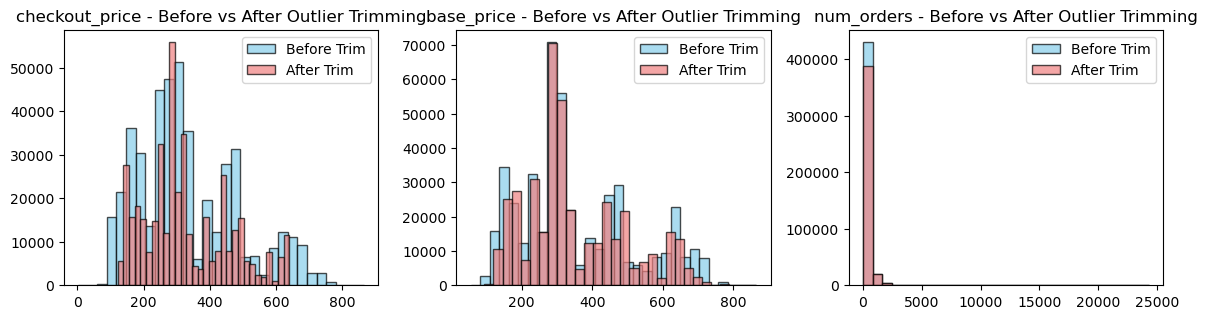

In [18]:
# Plot histograms for numerical columns before and after trimming outliers
plt.figure(figsize=(12, 6))
for i, col in enumerate(['checkout_price', 'base_price', 'num_orders']):
    plt.subplot(2, 3, i+1)
    plt.hist(df[col], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Before Trim')
    plt.hist(trimmed_df_cp[col], bins=30, color='lightcoral', edgecolor='black', alpha=0.7, label='After Trim')
    plt.title(f'{col} - Before vs After Outlier Trimming')
    plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# One-hot encode the 'quarter' column
encoded_quarters = pd.get_dummies(df['quarter'], prefix='quarter')

# Concatenate the encoded quarters with the original DataFrame
df_encoded = pd.concat([df, encoded_quarters], axis=1)

# Drop the original 'quarter' column as it's no longer needed
df_encoded.drop(columns=['quarter'], inplace=True)

In [20]:
# Convert 'base_price' and 'checkout_price' columns to integers
df['base_price'] = df['base_price'].astype(int)
df['checkout_price'] = df['checkout_price'].astype(int)

# Create a new column 'discount_amount' by calculating the discount
df['discount_amount'] = df['base_price'] - df['checkout_price']

# Normalize the 'num_orders' column between 0 and 1
df['num_orders_normalized'] = (df['num_orders'] - df['num_orders'].min()) / (df['num_orders'].max() - df['num_orders'].min())


# Display the transformed DataFrame
print("DataFrame after transformations:")
print(df)

DataFrame after transformations:
             id  week  center_id  meal_id  checkout_price  base_price  \
0       1379560     1         55     1885             136         152   
1       1466964     1         55     1993             136         135   
2       1346989     1         55     2539             134         135   
3       1338232     1         55     2139             339         437   
4       1448490     1         55     2631             243         242   
...         ...   ...        ...      ...             ...         ...   
456543  1271326   145         61     1543             484         484   
456544  1062036   145         61     2304             482         482   
456545  1110849   145         61     2664             237         321   
456546  1147725   145         61     2569             243         313   
456547  1361984   145         61     2490             292         290   

        emailer_for_promotion  homepage_featured  num_orders quarter  \
0                 

In [21]:
# Encode the 'quarter' column
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_encoded['quarter_encoded'] = label_encoder.fit_transform(df['quarter'])

In [22]:
# Define the number of weeks for training and testing
weeks_total = 145
weeks_training = int(0.8 * weeks_total)

# Split the dataset into training and testing sets based on the number of weeks
X_train = df_encoded.iloc[:weeks_training, :]
X_test = df_encoded.iloc[weeks_training:(weeks_training + 10), :]

# Check the shapes of the training and testing sets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (116, 18)
Testing set shape: (10, 18)


##  Training Machine Learning Models to predict and solve

# Linear Regression Model

In [23]:
# Define the features (X) and target variable (y) for training and test sets
X_train_features = X_train[['week', 'center_id', 'meal_id', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured', 'quarter_Q1', 'quarter_Q2', 'quarter_Q3', 'quarter_Q4', 'quarter_Q5', 'quarter_Q6', 'quarter_Q7', 'quarter_Q8']]
y_train = X_train['num_orders']

X_test_features = X_test[['week', 'center_id', 'meal_id', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured', 'quarter_Q1', 'quarter_Q2', 'quarter_Q3', 'quarter_Q4', 'quarter_Q5', 'quarter_Q6', 'quarter_Q7', 'quarter_Q8']]
y_test = X_test['num_orders']

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train_features, y_train)

# Make predictions on the test data
predictions = model.predict(X_test_features)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 63579.09473054332


In [24]:
model= LinearRegression()
model.fit(X_train, y_train)
Linearreg = model.predict(X_test)

print ('R2 score :',r2_score(y_test,Linearreg))
print ('MSE score :', mean_squared_error(y_test,Linearreg))
print ('RMSE: ',sqrt(mean_squared_error(y_test,Linearreg)))

R2 score : 1.0
MSE score : 6.196912618181762e-26
RMSE:  2.489359881210783e-13


# Decision Tree Model

In [25]:
# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=0.20, random_state=1956)

# Train Decision Tree model
DTRmodel = DecisionTreeRegressor(max_depth=3, random_state=0)
DTRmodel.fit(X_train2, y_train2)
y_pred = DTRmodel.predict(X_test2)

# Print evaluation metrics for Decision Tree model
print('Decision Tree R2 score:', r2_score(y_test2, y_pred))
print('Decision Tree MSE score:', mean_squared_error(y_test2, y_pred))
print('Decision Tree RMSE:', sqrt(mean_squared_error(y_test2, y_pred)))

Decision Tree R2 score: 0.9724032729101534
Decision Tree MSE score: 2168.7427940351645
Decision Tree RMSE: 46.5697626581365


# Random Forest Regression Model

In [26]:
# Split the data into training and testing sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_train, y_train, test_size=0.20, random_state=33)

# Train Decision Tree model
RFRmodel = RandomForestRegressor(max_depth=3, random_state=0)
RFRmodel.fit(X_train3, y_train3)
y_pred1 = RFRmodel.predict(X_test3)

# Print evaluation metrics for Decision Tree model
print('Random Forest R2 score:', r2_score(y_test3, y_pred))
print('Random Forest MSE score:', mean_squared_error(y_test3, y_pred1))
print('Random Forest RMSE:', sqrt(mean_squared_error(y_test3, y_pred1)))

Random Forest R2 score: -0.7514230837352303
Random Forest MSE score: 1399.3437930419677
Random Forest RMSE: 37.407803905628676


In [27]:
# Define the hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize the Random Forest Regression model
rf_model_tuned = RandomForestRegressor()

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(estimator=rf_model_tuned, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_features, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Fit the model with the best hyperparameters
rf_model_optimized = RandomForestRegressor(**best_params)
rf_model_optimized.fit(X_train_features, y_train)

# Make predictions on the test data
rf_predictions_optimized = rf_model_optimized.predict(X_test_features)

# Evaluate the model using mean squared error
rf_mse_optimized = mean_squared_error(y_test, rf_predictions_optimized)
print(f'Optimized Random Forest Mean Squared Error: {rf_mse_optimized}')

Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Optimized Random Forest Mean Squared Error: 94820.56076


In [28]:
# TITLE WHAT'S THIS

In [29]:
# Define parameter grids for hyperparameter tuning
param_grid_dt = {'max_depth': [3, 5, 7]}
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}

# Perform grid search with cross-validation for Decision Tree
grid_search_dt = GridSearchCV(DecisionTreeRegressor(), param_grid_dt, cv=5)
grid_search_dt.fit(X_train, y_train)

# Perform grid search with cross-validation for Random Forest
grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5)
grid_search_rf.fit(X_train, y_train)

# Get the best hyperparameters
best_params_dt = grid_search_dt.best_params_
best_params_rf = grid_search_rf.best_params_

print("Best hyperparameters for Decision Tree:", best_params_dt)
print("Best hyperparameters for Random Forest:", best_params_rf)

Best hyperparameters for Decision Tree: {'max_depth': 5}
Best hyperparameters for Random Forest: {'max_depth': 5, 'n_estimators': 100}


In [30]:
# Decision Tree with best hyperparameters
best_max_depth_dt = 5  # Best hyperparameter for max_depth
dt_model = DecisionTreeRegressor(max_depth=best_max_depth_dt)
dt_model.fit(X_train, y_train)


# Random Forest with best hyperparameters
best_max_depth_rf = 7  # Best hyperparameter for max_depth
best_n_estimators_rf = 100  # Best hyperparameter for n_estimators
rf_model = RandomForestRegressor(n_estimators=best_n_estimators_rf, max_depth=best_max_depth_rf)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=7)

In [31]:
# Predict on the test set with the decision tree model
y_pred_dt = dt_model.predict(X_test)

# Calculate the evaluation metrics
r2_dt = r2_score(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = sqrt(mse_dt)

# Print the evaluation metrics
print('Decision Tree Evaluation Metrics with Best Hyperparameters:')
print('R2 score:', r2_dt)
print('MSE score:', mse_dt)
print('RMSE:', rmse_dt)

Decision Tree Evaluation Metrics with Best Hyperparameters:
R2 score: 0.9979114580995337
MSE score: 319.95344545225464
RMSE: 17.88724253350009
